<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/rnn/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

Download NLTK data

In [0]:
%%capture
nltk.download("book")

Upload deep_learning_sentences.txt file (or another file containing a list of sentences if you wish)

In [193]:
from google.colab import files
uploaded = files.upload()

Saving deep_learning_sentences.txt to deep_learning_sentences (1).txt


Add sentence start and end tags, convert to lower case and strip newlines

In [0]:
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

In [0]:
with open('deep_learning_sentences.txt', 'r') as f:
  sentences = f.readlines()
sentences = ["%s %s %s" % (sentence_start_token, x.lstrip().rstrip('.\n').lower(), sentence_end_token) for x in sentences]

In [196]:
print("Parsed %d sentences." % (len(sentences)))
for i in range(0, 10):
  print("Example: %s" % sentences[i])

Parsed 7674 sentences.
Example: SENTENCE_START part ii  deep networks: modern  practices  166    this part of the book summarizes the state of modern deep learning as it is used to solve practical applications SENTENCE_END
Example: SENTENCE_START this part focuses only on those approaches that are essentially working tech- nologies that are already used heavily in industry SENTENCE_END
Example: SENTENCE_START by adding more layers and more units within a layer, a deep network can represent functions of increasing complexity SENTENCE_END
Example: SENTENCE_START most tasks that consist of mapping an input vector to an output vector, and that are easy for a person to do rapidly, can be accomplished via deep learning, given sufficiently large models and sufficiently large datasets of labeled training examples SENTENCE_END
Example: SENTENCE_START other tasks, that can not be described as associating one vector to another, or that are difficult enough that a person would require time to thin

Tokenize the sentences into words

In [0]:
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [198]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 13509 unique words tokens.


In [0]:
vocab_size = 1000
unknown_token = 'UNKNOWN_TOKEN'

In [0]:
vocab = word_freq.most_common(vocab_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i, w in enumerate(index_to_word)])

Replace all words not in our vocabulary with the unknown token and discard sentences under min / over max number of words

In [0]:
min_sentence_length = 10
max_sentence_length = 50

In [0]:
purged_sentences = []
for i, sent in enumerate(tokenized_sentences):
  if min_sentence_length <= len(sent) <= max_sentence_length:
    purged_sentences.append([w if w in word_to_index else unknown_token for w in sent])

In [203]:
print("Purged %d sentences." % (len(purged_sentences)))
for i in range(0, 10):
  print("Example: %s" % purged_sentences[i])

Purged 6791 sentences.
Example: ['SENTENCE_START', 'part', 'UNKNOWN_TOKEN', 'deep', 'networks', ':', 'modern', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'this', 'part', 'of', 'the', 'book', 'UNKNOWN_TOKEN', 'the', 'state', 'of', 'modern', 'deep', 'learning', 'as', 'it', 'is', 'used', 'to', 'solve', 'practical', 'applications', 'SENTENCE_END']
Example: ['SENTENCE_START', 'this', 'part', 'UNKNOWN_TOKEN', 'only', 'on', 'those', 'approaches', 'that', 'are', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'that', 'are', 'already', 'used', 'UNKNOWN_TOKEN', 'in', 'UNKNOWN_TOKEN', 'SENTENCE_END']
Example: ['SENTENCE_START', 'by', 'adding', 'more', 'layers', 'and', 'more', 'units', 'within', 'a', 'layer', ',', 'a', 'deep', 'network', 'can', 'represent', 'functions', 'of', 'increasing', 'UNKNOWN_TOKEN', 'SENTENCE_END']
Example: ['SENTENCE_START', 'most', 'tasks', 'that', 'UNKNOWN_TOKEN', 'of', 'mapping', 'an', 'input', 'vector', 'to', 'an', 'output', 'vector', ',', 'and', 'that', 'ar

Create the training data

In [0]:
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in purged_sentences])
Y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in purged_sentences])

Limit to 100 training examples to save time

In [0]:
X_train = X_train[0:100]
Y_train = Y_train[0:100]

In [206]:
print("Example: ", X_train[2])

Example:  [2, 22, 547, 66, 172, 11, 66, 78, 451, 8, 119, 1, 8, 43, 47, 18, 307, 127, 4, 753, 999]


In [0]:
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

In [0]:
class RNN:
    
  def __init__(self, word_dim, hidden_dim=100):
      # Assign instance variables
      self.word_dim = word_dim
      self.hidden_dim = hidden_dim
      # Randomly initialize the network parameters
      self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (word_dim, hidden_dim))
      self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, word_dim))
      self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
      self.b = np.zeros(hidden_dim)
      self.c = np.zeros(word_dim)

  def forward(self, x):
    # Do a forward pass for single example
    T = len(x)
    h = np.zeros((T , self.hidden_dim))
    o = np.zeros((T, self.word_dim))
    for t in range(T):
      # Note that we are indexing U by x[t]. This is the same as multiplying U with a one-hot vector.
      if t == 0:
        h[t] = self.U[x[t], :] + self.b
      else:
        h[t] = np.matmul(self.W.T, h[t-1]) + self.U[x[t], :] + self.b
      o[t] = softmax(np.matmul(self.V.T, h[t]) + self.c)
    return (o, h)

  def backward(self, x, y):
    #Do a backward pass for single example
    T = len(x)
    o, h = self.forward(x)
    # Accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdb = np.zeros(self.b.shape)
    dLdc = np.zeros(self.c.shape)
    # dL/do
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # dL/dh
    delta_h = np.zeros((T, self.hidden_dim))
    for t in reversed(range(T)):
      if t == T - 1:
        delta_h[t] = np.matmul(self.V, delta_o[t, :])
      else:
        delta_h[t] = np.matmul(np.matmul(self.W, np.diag(1 - h[t+1]**2)), delta_h[t+1]) + np.matmul(self.V, delta_o[t, :])
    # Accumulate gradients over time-steps
    for t in range(T):
      dLdV += np.outer(h[t, :], delta_o[t, :])
    return (dLdU, dLdV, dLdW, dLdb, dLdc)

  def step(self, x, y, learning_rate=0.1):
    # Perform SGD step for single example
    dLdU, dLdV, dLdW, dLdb, dLdc  = self.backward(x, y)
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW
    self.b -= learning_rate * dLdb
    self.c -= learning_rate * dLdc

  def loss(self, x, y):
    # Per example loss
    o, h = self.forward(x)
    return - np.sum(o[np.arange(len(y)), y])

  def generate_sentence(self, max_length=20):
    # We start the sentence with the start token
    new_sentence = [word_to_index[sentence_start_token]]
    # Repeat until we get an end token or reach maximum sentence length
    while not new_sentence[-1] == word_to_index[sentence_end_token] and len(new_sentence) < max_length:
      o, h = self.forward(new_sentence)
      sampled_word = word_to_index[unknown_token]
      # We don't want to sample unknown words or sentence start
      while sampled_word == word_to_index[unknown_token] or sampled_word == word_to_index[sentence_start_token]:
          samples = np.random.multinomial(1, o[-1])
          sampled_word = np.argmax(samples)
      new_sentence.append(sampled_word)
    sentence_str = [index_to_word[x] for x in new_sentence]
    return sentence_str


In [0]:
model = RNN(vocab_size)
model.step(X_train[0], Y_train[0])

Generate random sentences

In [297]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'activation', 'contain', 'weights', 'difficulty', 'same', 'without', 'drawn', 'second', 'shared', 'initialization', 'likely', 'prediction', 'a', '“', '←', 'i', 'assume', 'variation', 'functions']
['SENTENCE_START', 'some', 'm', 'interactions', 'sequences', 'architectures', 'uses', 'you', 'the', 'find', 'across', 'this', 'graphs', 'decay', 'kernel', 'distribution', 'interactions', 'initialization', 'translation', 'like']
['SENTENCE_START', 'appropriate', ']', 'at', 'want', 'well', 'algorithm', 'under', 'bias', 'variance', 'component', 'decoder', 'contain', 'variety', 'during', 'rbm', 'consists', 'predict', 'different', 'memory']
['SENTENCE_START', 'corresponds', 'knowledge', 'batch', 'down', 'e', 'precision', 'perform', 'practical', 'having', 'while', 'j', 'graphs', 'convolutional', 'multiplication', 'example', 'binary', 'represent', 'use', 'initialization']
['SENTENCE_START', 'without', 'together', 'choice', 'one', 'criterion', 'expression', 'recognition', 'x|', '”',

In [0]:
num_epochs = 10
learning_rate = 0.1

In [307]:
loss_history = []
for epoch in range(num_epochs):
  loss = 0
  for i in range(len(X_train)):
    loss += model.loss(X_train[i], Y_train[i])
  loss = loss / len(X_train)
  print("Epoch {0} Loss {1}".format(epoch , loss))
  loss_history.append(loss)
  for i in range(len(X_train)):
    model.step(X_train[i], Y_train[i], learning_rate=learning_rate)
    


Epoch 0 Loss -0.071015518684503
Epoch 1 Loss -0.07531378530298491
Epoch 2 Loss -0.07982976082562401
Epoch 3 Loss -0.0845355586598685
Epoch 4 Loss -0.08940008873406713
Epoch 5 Loss -0.09439110658429055
Epoch 6 Loss -0.09947726469627063
Epoch 7 Loss -0.1046299107276044
Epoch 8 Loss -0.10982444410143458
Epoch 9 Loss -0.11504113673470716


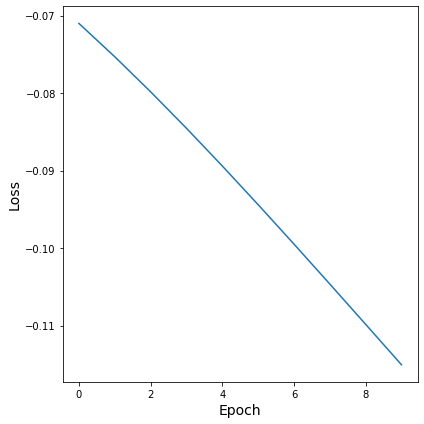

In [314]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(loss_history[:])
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.tight_layout()
plt.show()

In [315]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'performance', 'they', '5', 'control', 'transformation', 'rate', 'must', 'drawn', '←', 'partition', '2006', 'c', 'deviation', 'µ', 'available', 'remains', 'dependencies', 'density', 'important']
['SENTENCE_START', 'much', 'regression', 'train', 'suppose', 'ways', 'defining', 'apply', 'unit', '\ue050', 'kernel', 'm', 'where', 'view', 'constraint', 'fewer', 'shared', 'empirical', 'factors', 'j']
['SENTENCE_START', 'units', 'machine', 'starting', 'computational', 'complex', 'samples', 'connections', 'pseudolikelihood', '=', 'decay', 'view', '5', 'artificial', '6', 'basis', 'implementations', 'machine', 'applied', 'expected']
['SENTENCE_START', 'today', 'will', 'r', 'about', '8', 'already', 'belief', 'unfortunately', 'et', 'relevant', 'rather', 'using', 'computed', 'vision', 'c', 'require', 'many', 'propagation', 'newton']
['SENTENCE_START', 'several', 'running', 'see', 'conference', 'previous', 'implementations', 'model', 'chain', 'max', 'directly', 'gradient', 'valid',